# Are new movies longer than they were 10, 20, 50 year ago? 

**If you like to watch movies and I mean _a lot_ of movies, there is a chance that you noticed that movies nowadays are getting longer and longer. When was the last time you went to the cinema and watched a blockbuster which was shorter than 120 minutes? More and more movies (thank you Marvel for encouraging this trend!) have also scenes after subtitles, so you wait patiently all the way till the end, even if your bladder is killing you for some time already.**

**These are the times when you could think “Gosh, movies are getting ridiculously long lately”. Are they? I asked myself the same question. I discussed the matter with some fellow movie lovers. They had similar feelings. That wasn’t enough for me. I decided to use my data analysis skills to investigate this issue. In this article you can read what I have found out. **

## Dataset

There is no better place to look for data about movies than [IMDb.com](https://www.imdb.com/). It’s the biggest movie website in the world. Developed since 1990 (sic!), its database includes around 5.3 million titles and 9.3 million personalities. That’s unbelievable, but it started as the list of actresses with beautiful eyes (for real, check [IMDb history on Wikipedia](https://en.wikipedia.org/wiki/IMDb#History_before_website)).

IMDb data is available for personal use on the [IMDb Datasets page](https://datasets.imdbws.com/). We don’t need detailed database for our study. In our final dataset we only need three columns for each movie:
1. Release year
2. Runtime
3. Number of votes (to filter out niche movies)

We need to download two datasets and join them later. In _title.basics.tsv.gz_ there is a lot of data about every movie, TV show and episode in the database. In _title.ratings.tsv.gz_ there is info about number of votes and average rating of items from the database. 

Let’s start writing our script with crunching this huge amount of data and preparing it for further investigation. 


In [1]:
import pandas as pd, \
    matplotlib.pyplot as plt, \
    matplotlib.patches as mpatches, \
    matplotlib.lines as mlines, \
    seaborn as sns, \
    math
%matplotlib inline

In [2]:
# Download data from IMDB website
# Data description https://www.imdb.com/interfaces/
movies = pd.read_csv('https://datasets.imdbws.com/title.basics.tsv.gz', compression='gzip', sep='\t')
print('"title.basics.tsv.gz" downloaded')
ratings = pd.read_csv('https://datasets.imdbws.com/title.ratings.tsv.gz', compression='gzip', sep='\t')
print('"title.ratings.tsv.gz" downloaded')
print(movies.shape)
print(ratings.shape)

C:\tools\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


"title.basics.tsv.gz" downloaded
"title.ratings.tsv.gz" downloaded
(5972264, 9)
(947394, 3)


So far it looks good. We have two datasets. One has almost 950k rows and 3 columns, the other has almost 6 million entries and 11 columns. Both datasets have _tconst_ variable, which is unique id for every title. We can merge existing data on this column.

In [3]:
# Merge data on 'tconst', which is unique id for any title in IMDB database.
movies = pd.merge(movies, ratings, on='tconst')
print(movies.shape)

(947394, 11)


In total there are almost 950k unique titles.

## Getting rid of unnecessary data

Now we can investigate our data further. There is a column called _titleType_, which indicates if the title is a movie, TV show, episode, short etc. 


In [4]:
print(movies['titleType'].unique())

['short' 'movie' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvShort' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame']


There are 10 types of titles. We are interested only in movies, so we will leave in our dataset rows marked as _movie_. We could argue if we should consider TV movies. However, TV movies are usually created to fit certain format, so they never get extraordinally long or short. Using them could add unnecessary noise to our dataset. 

In [5]:
movies = movies[movies['titleType'].isin(['movie'])]
print(movies.shape)

(235678, 11)


The number of titles dropped to 235k. 

Another thing we should consider are possible genres of the movies. We need to be sure that we consider only feature movies, not documentaries etc. We can check the _genres_ column. 

In [6]:
genres = movies['genres'].unique()
len(genres)

1239

There are 1239 unique genres! IMDb has a bad way to build database, because there is only one column for the genre. If a movie is considered a drama, comedy and fantasy at once, it will be written as _Comedy,Drama,Fantasy_. After looking through the array, I could find for example:
+ Documentary,News,Sport
+ Biography,Drama,History
+ Documentary,War
+ Animation,Musical,Sci-Fi
+ Crime,Documentary,Sport

This column is a mess. Since first draft of this article to publishing it 4 _new genres_ were added. Fortunately, we don’t need to deal with this. We only want to filter out documentaries. Pandas has a great tool to filter rows containing some string.

In [7]:
movies = movies[movies['genres'].str.contains('Documentary') == False]

Finally we have only the movies we need in our data. Now we can drop all unnecessary columns. As stated before, we only need three columns:
1.	_startYear_ - represents the release year of a title
2.	_runtimeMinutes_ - primary runtime of the title, in minutes
3.	_numVotes_ - number of votes the title has received

In [8]:
movies = movies[['startYear', 'runtimeMinutes', 'numVotes']]

In the end we need to change data type of those columns to numeric and drop rows with missing values. 

In [9]:
for column in movies.columns.values.tolist():
    movies[column] = pd.to_numeric(movies[column], errors='coerce')
movies = movies.dropna()
print(movies.shape)

(177908, 3)


After this step our number of movies dropped to 177.9k.

Before we continue with further analysis, it is good to check descriptive statistics of our dataset to determine if everything looks all right. 

In [10]:
print(movies.describe())

           startYear  runtimeMinutes      numVotes
count  177908.000000   177908.000000  1.779080e+05
mean     1988.416299       95.704004  4.195987e+03
std        25.801545       24.554865  3.474094e+04
min      1894.000000        6.000000  5.000000e+00
25%      1971.000000       84.000000  1.900000e+01
50%      1996.000000       92.000000  7.200000e+01
75%      2011.000000      104.000000  3.890000e+02
max      2019.000000     1500.000000  2.107885e+06


We can notice that at least one movie is only 6 minutes long, which doesn’t look right. There are probably some mistakes in the database. 

According to the Academy of Motion Picture Arts and Sciences, an original film needs to be [40 minutes or less to qualify as a short film](https://www.oscars.org/sites/oscars/files/91aa_short_films.pdf), whereas a feature film is more than 40 minutes. That’s a great rule to drop movies which are too short.

In [11]:
movies = movies[movies['runtimeMinutes'] > 40]

What’s more important, we are only interested in popular movies. There are thousands of movies in IMDb database which have only a few dozen votes. They can skew our results. Let’s say we will use 20% of most movies which got the most votes in every year. In the first draft fix limit of 1000 votes was used, but then older movies were not represented enough (users tend to watch and rate new moveis more often). Good bye thousands of B movies and garage productions!

In [12]:
popular_movies = pd.DataFrame()
for year in range(1894, 2020):
    movies_year = movies[movies['startYear'] == year].sort_values(by=['numVotes'], ascending=False)
    if len(movies_year) > 10:  # Quick filter to eliminate experimental years of cinema
        num_of_movies = math.floor(0.2 * len(movies_year))
        twenty_percent = movies_year.iloc[0:num_of_movies]  # subset of 20% of most popular movies
        popular_movies = popular_movies.append(twenty_percent)

movies = popular_movies
print(movies.describe())

          startYear  runtimeMinutes      numVotes
count  35531.000000    35531.000000  3.553100e+04
mean    1988.454899      103.195294  2.054965e+04
std       25.770115       23.148555  7.555841e+04
min     1911.000000       45.000000  6.600000e+01
25%     1971.000000       90.000000  1.018000e+03
50%     1996.000000       99.000000  2.287000e+03
75%     2011.000000      112.000000  8.077000e+03
max     2019.000000      729.000000  2.107885e+06


In our final dataset there are 35,531 movies. The shortest one is 45 minutes long and the longest is 729 minutes long (the prize of Iron Bladder goes to anyone who can watch it without bathroom break!). The oldest movie(s) is(are) from 1911. 

On average every movie in our dataset have 20k votes, but the standard deviation is 75k, which means that the distribution is skewed right (a movies cannot get negative number of votes) and the mean is overvalued by minority of movies with huge amount of votes (there is at least one movie with over 2 million ratings!). Median looks closer to reality, 50% of movies have 2.2k votes or less. 

_This study was done in two separate Python scripts, but in this notebook we joined them. The paragraphs below are not needed here, but they describe well how the dataset got **much** smaller._

Now we can save our data to CSV and move to a new script. This one takes a long time to execute. Python needs to download in total over 100MB data and process it few times. If we start over with a new script and smaller dataset, our workflow will be much faster. 

```movies.to_csv('movies.csv', index=False)
print('Success!')
Success!
```

New dataset has the size of 643 KB, less than 1% of the original ones! That’s how you get rid of irrelevant data! 

Let’s create a new script called movies.py.

```import pandas as pd, \
    matplotlib.pyplot as plt, \
    matplotlib.patches as mpatches, \
    matplotlib.lines as mlines, \
    seaborn as sns
movies = pd.read_csv('movies.csv')
```

## Looking for the first year to use in the study

We should start with thinking about the first year of our studies. Cinematography in the beginning of XX century was still in its infancy. There were not many movies created back then and most of them were just short presentations of the new technology and experiments. Let’s make a histogram with a number of titles in our dataset from these early years of movie history.

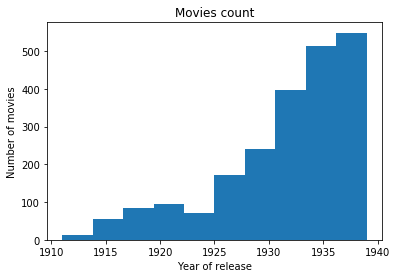

In [13]:
plt.hist(movies['startYear'][movies['startYear'] < 1940])
plt.title('Movies count')
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.show()

Ok, somewhere around early 1930’s number of movies starts to increase. Let’s take a closer look at the years before 1930: 

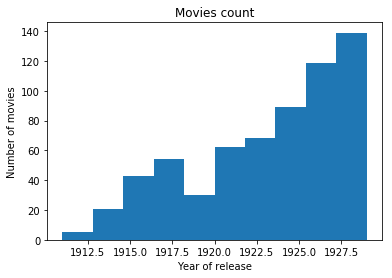

In [14]:
plt.hist(movies['startYear'][movies['startYear'] < 1930])
plt.title('Movies count')
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.show()

These are just histograms with default numbers of bins (10), we just use it to quickly visualize our data. If we want to know the exact number of movies in our dataset, we should instead look at the table (or create histogram with more bins). 

In [15]:
print(movies['startYear'][movies['startYear'] < 1940].value_counts().sort_index())

1911.0      2
1912.0      3
1913.0      8
1914.0     13
1915.0     17
1916.0     26
1917.0     26
1918.0     28
1919.0     30
1920.0     31
1921.0     31
1922.0     33
1923.0     35
1924.0     37
1925.0     52
1926.0     62
1927.0     57
1928.0     62
1929.0     77
1930.0    102
1931.0    121
1932.0    139
1933.0    138
1934.0    156
1935.0    173
1936.0    186
1937.0    191
1938.0    184
1939.0    174
Name: startYear, dtype: int64


There are only 2 movies from 1911 in our dataset. This is not enough data to create reliable results. We need to decide what year we should start with. I decided to use the same rule of thumb as with popular approach to normal distribution. According to that, minimum sample size to create it is 30. Now we can calculate starting year of our data. 

In [23]:
start_year = 0  # This will be starting year of the data.
# Create data frame with the year as a first column and movie count as a second.
movies_per_year = movies['startYear'].value_counts().sort_index()  # The year is an index, we need it as a column.
movies_per_year_df = pd.DataFrame({'year': movies_per_year.index, 'movie_count': movies_per_year.values}, 
                                  columns=['year', 'movie_count'])

for i in range(0, len(movies_per_year_df)):
    year = movies_per_year_df.iloc[i, 0]
    movie_count = movies_per_year_df.iloc[i, 1]
    # Check if in a given year there were at least 30 movies.
    if movie_count >= 30:
        movies_per_year_df = movies_per_year_df.iloc[i:, :]  # Drop years before current one in the loop
        # Check whether the rest of years in dataset have movie count above 30, if not, the loop continues.
        # If every year left has movie count above 30, the loop breaks and we have the answer.
        if sum(movies_per_year_df['movie_count'] < 30) == 0:
            start_year = year
            break

print(start_year)


1919.0


Our dataset will start from the year 1919. Of course, we could take a quick peek at the table above to determine it, but the goal was to practice loops and conditions to automate the process in case of more complicated data. In addition we will ignore movies from 2019, because it's not ended yet and the data can be flawed.

In [28]:
movies = movies[(movies['startYear'] >= start_year) & (movies['startYear'] < 2019)]
movies.describe()

,startYear,runtimeMinutes,numVotes
count,35074.000000,35074.000000,3.507400e+04
mean,1988.418316,103.185066,2.071771e+04
std,25.405027,22.904748,7.595682e+04
min,1919.000000,45.000000,9.700000e+01
25%,1971.000000,90.000000,1.030250e+03
50%,1996.000000,99.000000,2.309000e+03
75%,2011.000000,112.000000,8.164000e+03
max,2018.000000,729.000000,2.107885e+06


Our final dataset consists of 35,074 titles. What’s interesting, the median release year is 1996, which means that 50% of all movies in our dataset were released in 1996 or later. It means that either there is more and more movies being created, or the database itself contains bigger portion of newer titles than older ones. Median for runtime is 99 minutes and the mean is 103 minutes, which looks right. 

## Getting to the point 

Let’s plot distribution of runtimes. We limited it to 40-200 minutes range to improve readability. There are not many titles longer than 200 minutes and 40 minutes is lower band of our data. Every bin corresponds to 10 minute range. 

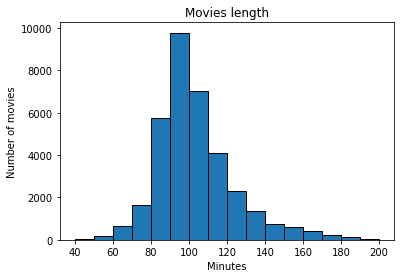

In [29]:
plt.hist(movies['runtimeMinutes'], range=(40, 200), bins=16, ec='black')
plt.title('Movies length')
plt.xlabel('Minutes')
plt.ylabel('Number of movies')
plt.show()

The most popular runtime is 90-100 minutes. Vast majority of movies is 80-130 minutes long. This is consistent with our movie-watching intuition.

Let's find an average movie runtime by year. We group dataset by year and get descriptive statistics of every subset.

In [30]:
statistics_grouped = movies['runtimeMinutes'].groupby(movies['startYear']).describe()

We can create a plot of this data. Besides average movie runtime we can also create confidence interval based on the standard deviation. We will use simple formulas for that:

In [31]:
avg_runtime_by_year = statistics_grouped['mean']  # Mean
avg_runtime_lower_band = statistics_grouped['mean'] - statistics_grouped['std']  # Lower band of data created using standard deviation.
avg_runtime_upper_band = statistics_grouped['mean'] + statistics_grouped['std']  # Upper band of data.

Let’s create the plot:

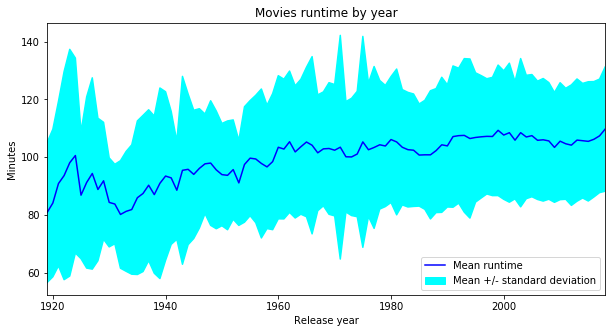

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(avg_runtime_by_year, color="blue")
ax1.plot(avg_runtime_lower_band, color="aqua")
ax1.plot(avg_runtime_upper_band, color="aqua")
ax1.fill_between(statistics_grouped.index, avg_runtime_lower_band, avg_runtime_upper_band, facecolor='aqua')  # Fill space between bands to create confidence interval.
ax1.set_title('Movies runtime by year')
ax1.set_ylabel('Minutes')
ax1.set_xlabel('Release year')
ax1.set_xlim(start_year, 2018)
legend_sd = mpatches.Patch(color='aqua', label='Mean +/- standard deviation')  # Used mpatches to create rectangular for a legend.
legend_line = mlines.Line2D([], [], color='blue', label='Mean runtime')
ax1.legend(handles=[legend_line, legend_sd])  # Pretty legend with rectangular and line.
plt.show()

Looks like our intuitive thinking about movies getting longer was wrong. In the early '20s the lenght of movies increased, but then dropped back to 80 minutes. It’s true that in the first decades of cinema movies were shorter, they were on average 90 minutes long in early 1930s and reached 100-110 minutes in mid-‘50s. Since then there is no trend in our data. Also the confidence interval is fairly consistent with 80-130 minutes runtime.

_However, it looks like 2018 can be a beginning of new uptrend, because it’s one of two years in movie history when the average runtime was longer than 110 minutes. It’s too soon to speculate, but we need to take a closer look in the future. _

We can wonder what part of our dataset was considered when creating confidence interval. It’s easy to check that. We need to find a number of movies longer (shorter) than lower (upper) band of the confidence interval and divide it by the number of all movies from given year. 

In [34]:
percentage_of_included_movies = []
for year in statistics_grouped.index:
    movies_from_year = movies[movies['startYear'] == year]
    avg_runtime_low = avg_runtime_lower_band[int(year)]
    avg_runtime_up = avg_runtime_upper_band[int(year)]
    movies_included = movies_from_year[movies_from_year['runtimeMinutes'] > avg_runtime_low][movies_from_year['runtimeMinutes'] < avg_runtime_up]
    percentage_of_included_movies.append(len(movies_included)/len(movies_from_year))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Now we can add new column to our _statistics_grouped_ data frame:

In [35]:
statistics_grouped['included_movies_perc'] = percentage_of_included_movies
print(statistics_grouped['included_movies_perc'].describe())

count    100.000000
mean       0.802699
std        0.062156
min        0.594595
25%        0.769127
50%        0.806735
75%        0.842438
max        0.962319
Name: included_movies_perc, dtype: float64


On average 80% of movies from every year fit into the confidence interval. We can add extra line to our previous plot showing this proportion by year. 

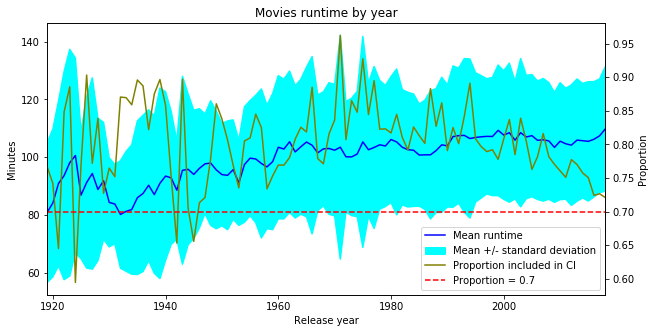

In [36]:
# Main plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(avg_runtime_by_year, color="blue")
ax1.plot(avg_runtime_lower_band, color="aqua")
ax1.plot(avg_runtime_upper_band, color="aqua")
ax1.fill_between(statistics_grouped.index, avg_runtime_lower_band, avg_runtime_upper_band, facecolor='aqua')
ax1.set_title('Movies runtime by year')
ax1.set_ylabel('Minutes')
ax1.set_xlabel('Release year')
ax1.set_xlim(start_year, 2018)
# Plot with proportions
ax2 = ax1.twinx()
ax2.plot(statistics_grouped['included_movies_perc'], color='olive')
ax2.set_ylabel('Proportion')
plt.axhline(y=0.70, color='red', linestyle='dashed')  # Add line at 0.70
legend_sd = mpatches.Patch(color='aqua', label='Mean +/- standard deviation')
legend_line = mlines.Line2D([], [], color='blue', label='Mean runtime')
legend_line_2 = mlines.Line2D([], [], color='olive', label='Proportion included in CI')
dashed_line = mlines.Line2D([], [], color='red', label='Proportion = 0.7', linestyle='dashed')
ax1.legend(handles=[legend_line, legend_sd, legend_line_2, dashed_line])
plt.show()

The plot looks a little messy, but the message is clear. Except for small dump in mid-'30s our confidence interval contained more than 70% of titles every year. 

Let’s create another plot, this time with median and interquartile range and check the results. We are mostly interested in the confidence interval, which will now contain 50% movies. 25% of the shortest titles and 25% of the longest ones will be outside the blue area.

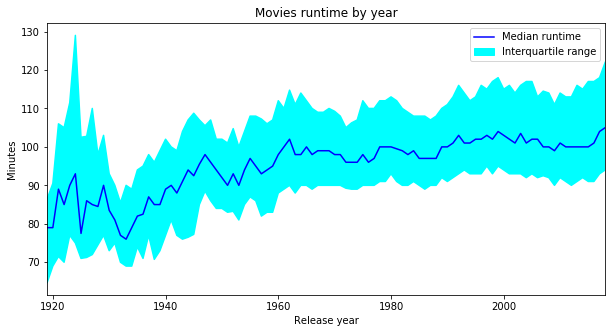

In [37]:
# Data
avg_runtime_by_year = statistics_grouped['50%']
avg_runtime_lower_band = statistics_grouped['25%']
avg_runtime_upper_band = statistics_grouped['75%']


# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(avg_runtime_by_year, color="blue")
ax1.plot(avg_runtime_lower_band, color="aqua")
ax1.plot(avg_runtime_upper_band, color="aqua")
ax1.fill_between(statistics_grouped.index, avg_runtime_lower_band, avg_runtime_upper_band, facecolor='aqua')
ax1.set_title('Movies runtime by year')
ax1.set_ylabel('Minutes')
ax1.set_xlabel('Release year')
ax1.set_xlim(start_year, 2018)
legend_sd = mpatches.Patch(color='aqua', label='Interquartile range')
legend_line = mlines.Line2D([], [], color='blue', label='Median runtime')
ax1.legend(handles=[legend_line, legend_sd])
plt.show()

Here we also cannot see any clear pattern. However, the jump in recent 2-3 years is quite high. Still, it doesn’t mean this is the start of new trend, but we should check that sentiment in the future. We can also notice, that the median is on average lower than the mean. It fluctuates around 100 minutes, about 5 minutes shorter than the mean. It makes sense, because mean is affected by a small percentage of long movies and median is just the central value from every year. 

OK, so now we know that movies _in general_ are not getting longer. Maybe our intuition wasn’t wrong and it only happens with the most popular movies, the biggest blockbusters. We can create few more plots and every time consider smaller sample of most popular movies from every year.

Let’s take a look only at movies since 1960, so we can have a closer look at data most interesting for us. Maybe if we take only 50 most popular movies from every year, there will be some trend visible.


In [38]:
movies_since_1960 = movies[movies['startYear'] >= 1960]

Because we want to check few different values, we can create a function to return statistics about n most popular movies from every year. We can use it later. 

In [39]:
def top_n_movies(data, n):
    top_n_movies_per_year = data.groupby('startYear').head(n)
    stats = top_n_movies_per_year['runtimeMinutes'].groupby(
        top_n_movies_per_year['startYear']).describe()
    return stats

Now we can get the data needed and create our plot.

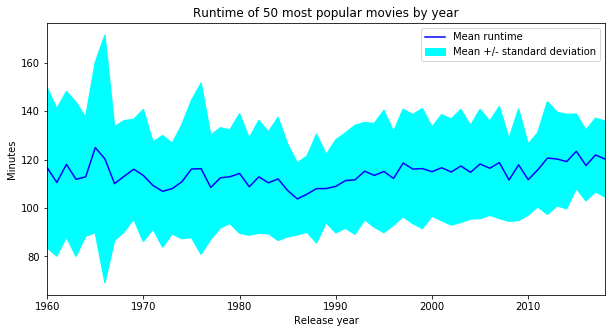

In [40]:
statistics_grouped_50 = top_n_movies(movies_since_1960, 50)

# Data
avg_runtime_by_year = statistics_grouped_50['mean']
avg_runtime_lower_band = statistics_grouped_50['mean'] - statistics_grouped_50['std']
avg_runtime_upper_band = statistics_grouped_50['mean'] + statistics_grouped_50['std']

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(avg_runtime_by_year, color="blue")
ax1.plot(avg_runtime_lower_band, color="aqua")
ax1.plot(avg_runtime_upper_band, color="aqua")
ax1.fill_between(statistics_grouped_50.index, avg_runtime_lower_band, avg_runtime_upper_band, facecolor='aqua')
ax1.set_title('Runtime of 50 most popular movies by year')
ax1.set_ylabel('Minutes')
ax1.set_xlabel('Release year')
ax1.set_xlim(1960, 2018)
legend_sd = mpatches.Patch(color='aqua', label='Mean +/- standard deviation')
legend_line = mlines.Line2D([], [], color='blue', label='Mean runtime')
ax1.legend(handles=[legend_line, legend_sd])
plt.show()

There is still no visible trend. What’s more, when we consider smaller amount of more popular movies, even the peak from 2017-2018 disappears.

What if we take a look at 30 most popular movies? Or 10? We can create new plot with means for different values. This time we will drop confidence intervals. Our `top_n_movies function` will be useful to do that. 

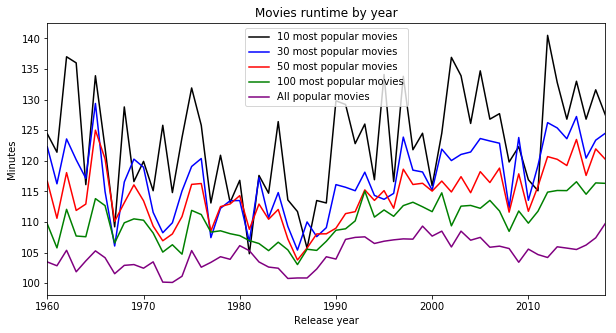

In [43]:
mean_10 = top_n_movies(movies_since_1960, 10)['mean']
mean_30 = top_n_movies(movies_since_1960, 30)['mean']
mean_50 = top_n_movies(movies_since_1960, 50)['mean']
mean_100 = top_n_movies(movies_since_1960, 100)['mean']
mean_all = top_n_movies(movies_since_1960, len(movies_since_1960))['mean']

# Chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mean_10, color='black')
ax.plot(mean_30, color='blue')
ax.plot(mean_50, color='red')
ax.plot(mean_100, color='green')
ax.plot(mean_all, color='purple')
ax.set_title('Movies runtime by year')
ax.set_ylabel('Minutes')
ax.set_xlabel('Release year')
ax.set_xlim(1960, 2018)
ax.legend(labels=['10 most popular movies',
                  '30 most popular movies',
                  '50 most popular movies',
                  '100 most popular movies',
                  'All popular movies'])
plt.show()

It looks like _in general_ more popular movies are longer (no trend in time). When we consider less movies from every year, there is more volatility on the chart, which is in pair with our statistical intuition – smaller sample leads to higher volatility.

Let's create a table with mean from all n-most popular movies of the year - mean of means. 

In [44]:
total_mean = pd.Series()
mean_list = [mean_10, mean_30, mean_50, mean_100, mean_all]
index_list = ['top_10', 'top_30', 'top_50', 'top_100', 'all']
for i in range(0, 5):
    mean_n = pd.Series([mean_list[i].mean()], index=[index_list[i]])
    total_mean = total_mean.append(mean_n)

print(total_mean)

top_10     123.098305
top_30     117.022034
top_50     114.117627
top_100    110.207627
all        104.764346
dtype: float64


You can clearly see the difference between means. The smaller sample from each year we take, the longer is the mean runtime. That could be the reason that a lot of people think that movies are longer than they used to be. It's just _the most popular_ movies are longer than _regular_ ones. The trend is in the _popularity_ of movies, not their _release date_. 

We looked at the movie runtimes year after year. Let’s create one last plot. This time we will generalize and create a new dataset with the decade movies were released instead of a year. Thanks to that we will have smaller number of groups and we can create a boxplots for them. 

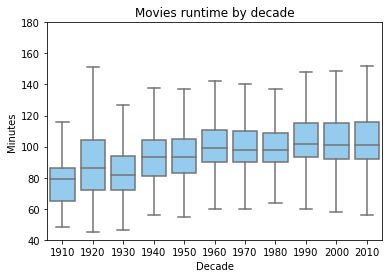

In [45]:
movies_by_decade = movies.copy()
movies_by_decade['startYear'] = ((movies_by_decade['startYear'] // 10) * 10).astype('int64')
sns.boxplot(x="startYear", y="runtimeMinutes", data=movies_by_decade, color='lightskyblue', showfliers=False)
plt.ylim(40,180)
plt.title('Movies runtime by decade')
plt.xlabel('Decade')
plt.ylabel('Minutes')
plt.show()

There is a big jump in 1920's and between 1930’s and 1940’s, then a smaller one after 1950’s and since then the differences are marginal. 

__In conclusion, our intuition was wrong. There is no trend in the movies runtime. The differences are too small to be noticed. We can say that for the last 60 years movies on average have the same length. No matter what criteria we take into account, the result is the same. However, the more popular movie we watch, the longer it could be. Thanks for the read! Now we can go back to watching movies! __